In [1]:
import numpy as np
import sys

sys.path.append('../../spinosaurus/')

from matplotlib import pyplot as plt
from spinosaurus.density_shape_correlators_fftw import DensityShapeCorrelators
from spinosaurus.Utils.loginterp import loginterp
from spinosaurus.za_densshape import DensityShapeCorrelators as ZACorr
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

This notebook generates the figures of Chen & Kokron 2023 [arXiv:XXXXXXXXXX]. Note these are generated with _very high_ numbers of points and will in general be slower than the kinds of fits used for MCMC runs. 

# Load in linear P(k), set redshift for $N$-body comparison

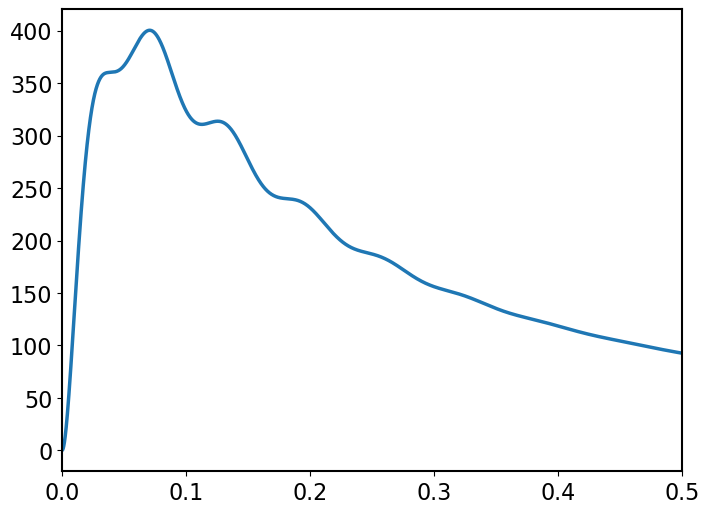

In [2]:
klin, plin = np.loadtxt('../data/power_lin.dat', unpack=True)

from scipy.special import hyp2f1
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def D_of_a(a,OmegaM=0.3089):
    return a * hyp2f1(1./3,1,11./6,-a**3/OmegaM*(1-OmegaM)) / hyp2f1(1./3,1,11./6,-1/OmegaM*(1-OmegaM))

z = 0.51
Dz = D_of_a(1./(1+z))


plin = Dz**2 * plin

plt.plot(klin, klin * plin)
plt.xlim(0,0.5)


#Compute ZA correlators
zapreds = ZACorr(klin,  plin,  N=4000)

zapreds.make_gdtable(nk=400)

#Compute full LPT correlators
lpt = DensityShapeCorrelators(klin, plin, kIR=0.2, N=4000)

lpt.make_gdtable(nk=400)

ks = lpt.pktable_gd[:,0]

# Generating Figure 1 

Load density x shape correlators and plot only those associated with the matter x shape correlators

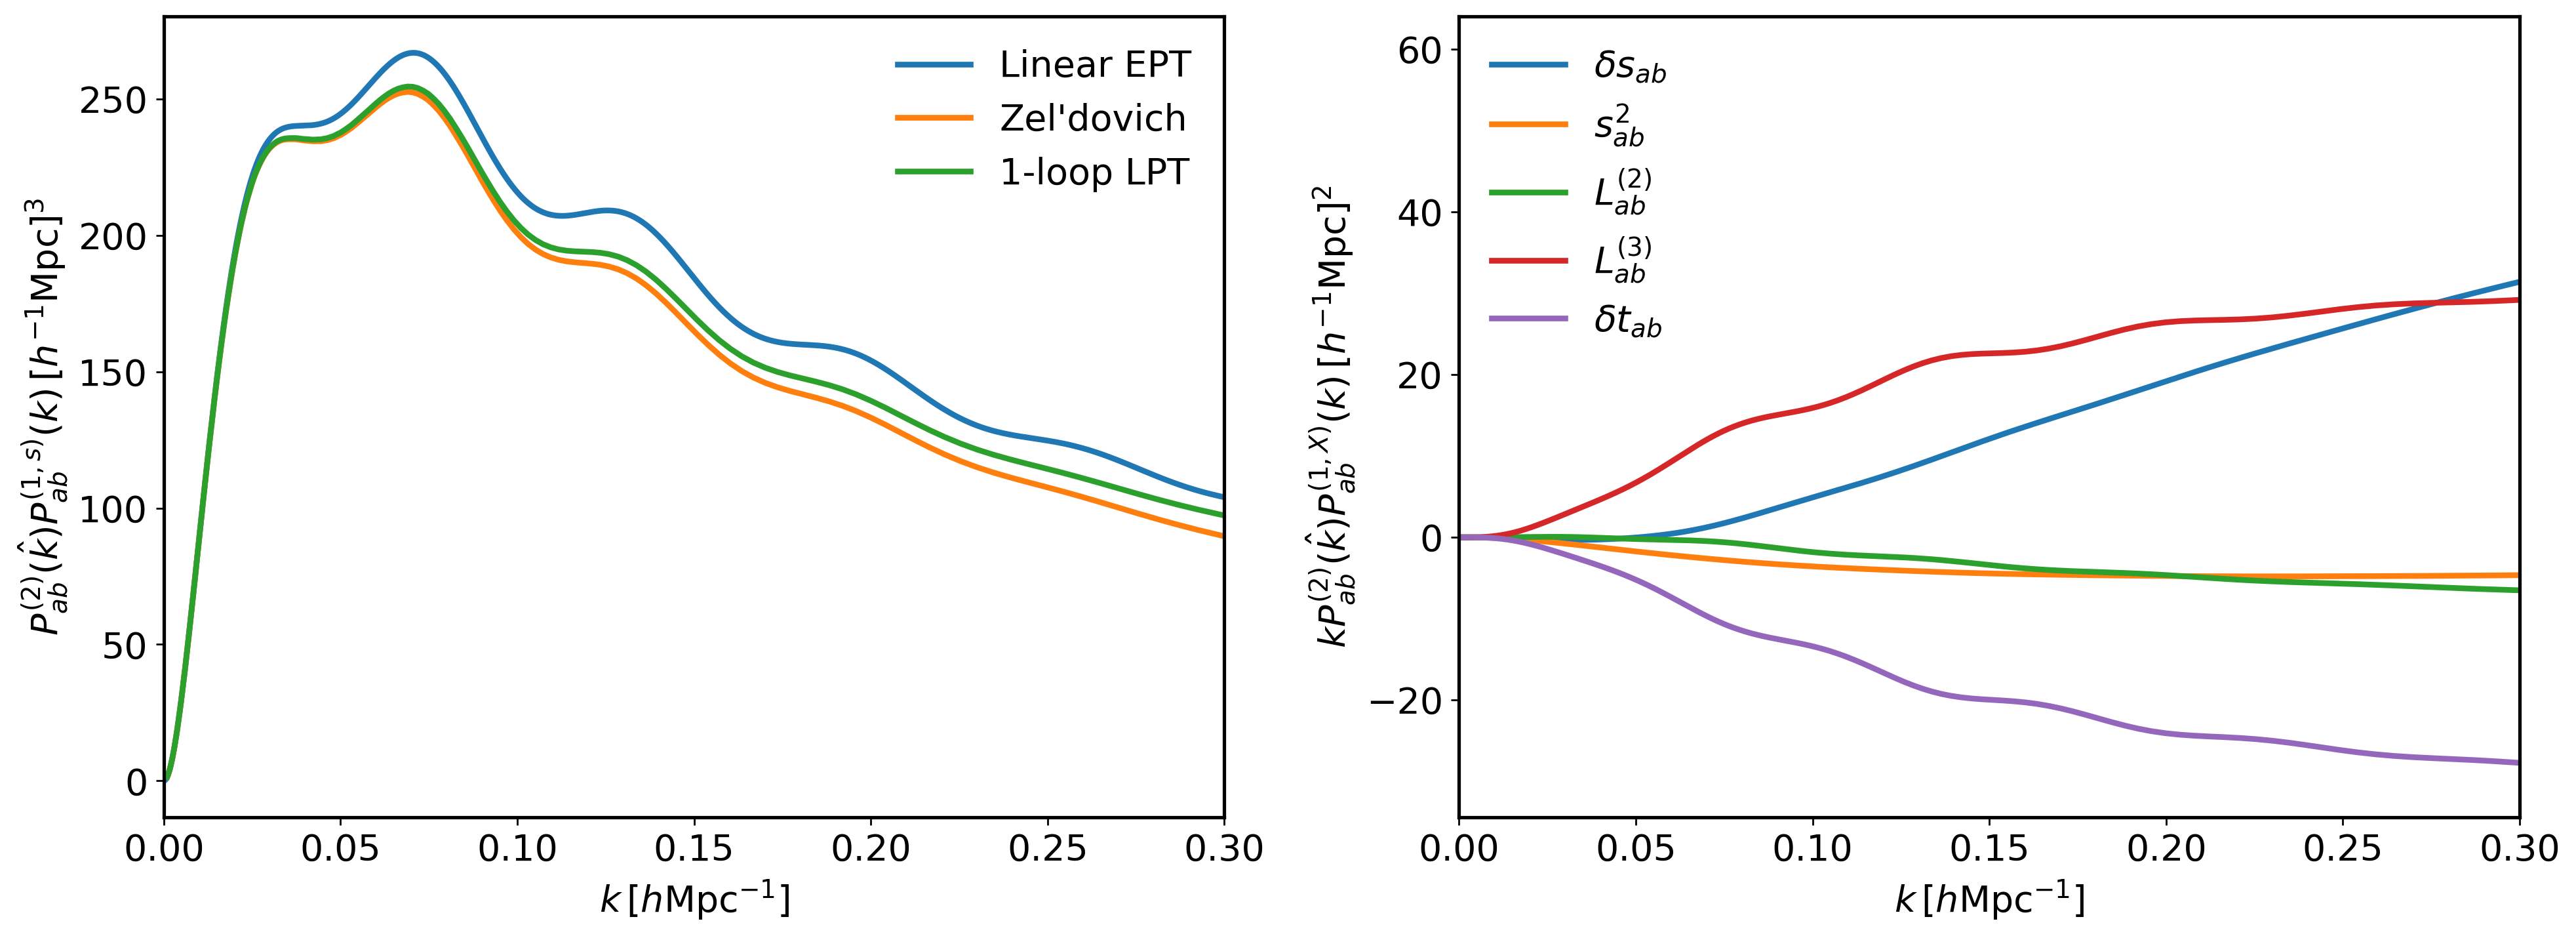

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi=250, sharex=True, facecolor='w')


labelvec = [
    r'$s_{ab}$', 
    r'$\delta s_{ab}$', 
    r'$s^2_{ab}$', 
    r'$L^{(2)}_{ab}$', 
    r'$(\delta, s_{ab})$', 
    r'$(\delta, \delta s_{ab})$', 
    r'$(\delta , s^2_{ab})$',
    r'$(\delta, t_{ab})$', 
    r'$(\delta^2, s_{ab})$', 
    r'$(\delta^2, \delta s_{ab})$', 
    r'$(\delta^2, s^2_{ab})$', 
    r'$(\delta^2, t_{ab})$', 
    r'$(s^2, s_{ab})$', 
    r'$(s^2, \delta s_{ab})$', 
    r'$(s^2, s^2_{ab})$', 
    r'$(s^2, t_{ab})$',     
    r'$L^{(3)}_{ab}$', 
    r'$(\delta, L^{(3)}_{ab})$', 
    r'$\delta t_{ab}$', 
    r'$(\delta, \delta t_{ab})$']

ax[0].plot(klin, klin*2/3 * plin, label=r'Linear EPT')
ax[0].plot(ks, ks*zapreds.pktable_gd[:,1], label=r"Zel'dovich")
ax[0].plot(ks, ks*lpt.pktable_gd[:,1], label=r'1-loop LPT')

ax[0].set_xlim(1e-3, 0.5)
ax[0].legend(framealpha=False)
ax[0].set_xlabel(r'$k\, [h {\rm Mpc}^{-1}]$')
ax[0].set_ylabel(r'$P^{(2)}_{ab}(\hat{k}) P^{(1,s)}_{ab}(k)\, [h^{-1} {\rm Mpc}]^3$')



for i in [1, 2, 3, 16, 18]:
    cfac = 1
    
    ax[1].plot(lpt.pktable_gd[:,0], cfac*(lpt.pktable_gd[:,0] * lpt.pktable_gd[:,i+1]), label=labelvec[i])

# plt.plot(ks, ks*beyondlin.pktable_gd[:,1], label='Corrections\n to $(1,s_{ab})$', ls='--', color='k', alpha=0.3)
ax[1].legend(framealpha=False)
ax[1].set_xlabel(r'$k\, [h {\rm Mpc}^{-1}]$')
ax[1].set_ylabel(r'$k P^{(2)}_{ab}(\hat{k}) P^{(1,X)}_{ab}(k)\, [h^{-1} {\rm Mpc}]^2$')
ax[1].set_xlim(0, 0.3)
fig.tight_layout()
fig.savefig('matterdens_2panel.pdf', format='pdf')

# Generate Figure 2

Load in hankel transform material, look at kIR variation

In [4]:
from spinosaurus.Utils.qfuncfft import QFuncFFT
from  spinosaurus.Utils.spherical_bessel_transform import SphericalBesselTransform
from  spinosaurus.Utils.loginterp import loginterp
sph = SphericalBesselTransform(klin, L=5, low_ring=True, fourier=True)

qv = np.logspace(-5,5,int(2e4))

sphr = SphericalBesselTransform(qv, L=5, low_ring=True, fourier=False)


### Get the EPT prediction, this is just a j_2 transform of the linear power spectrum.
#Multiplied by 2/3 will give the quadrupole-projected contribution. 
r, xi2 = sph.sph(2, plin)



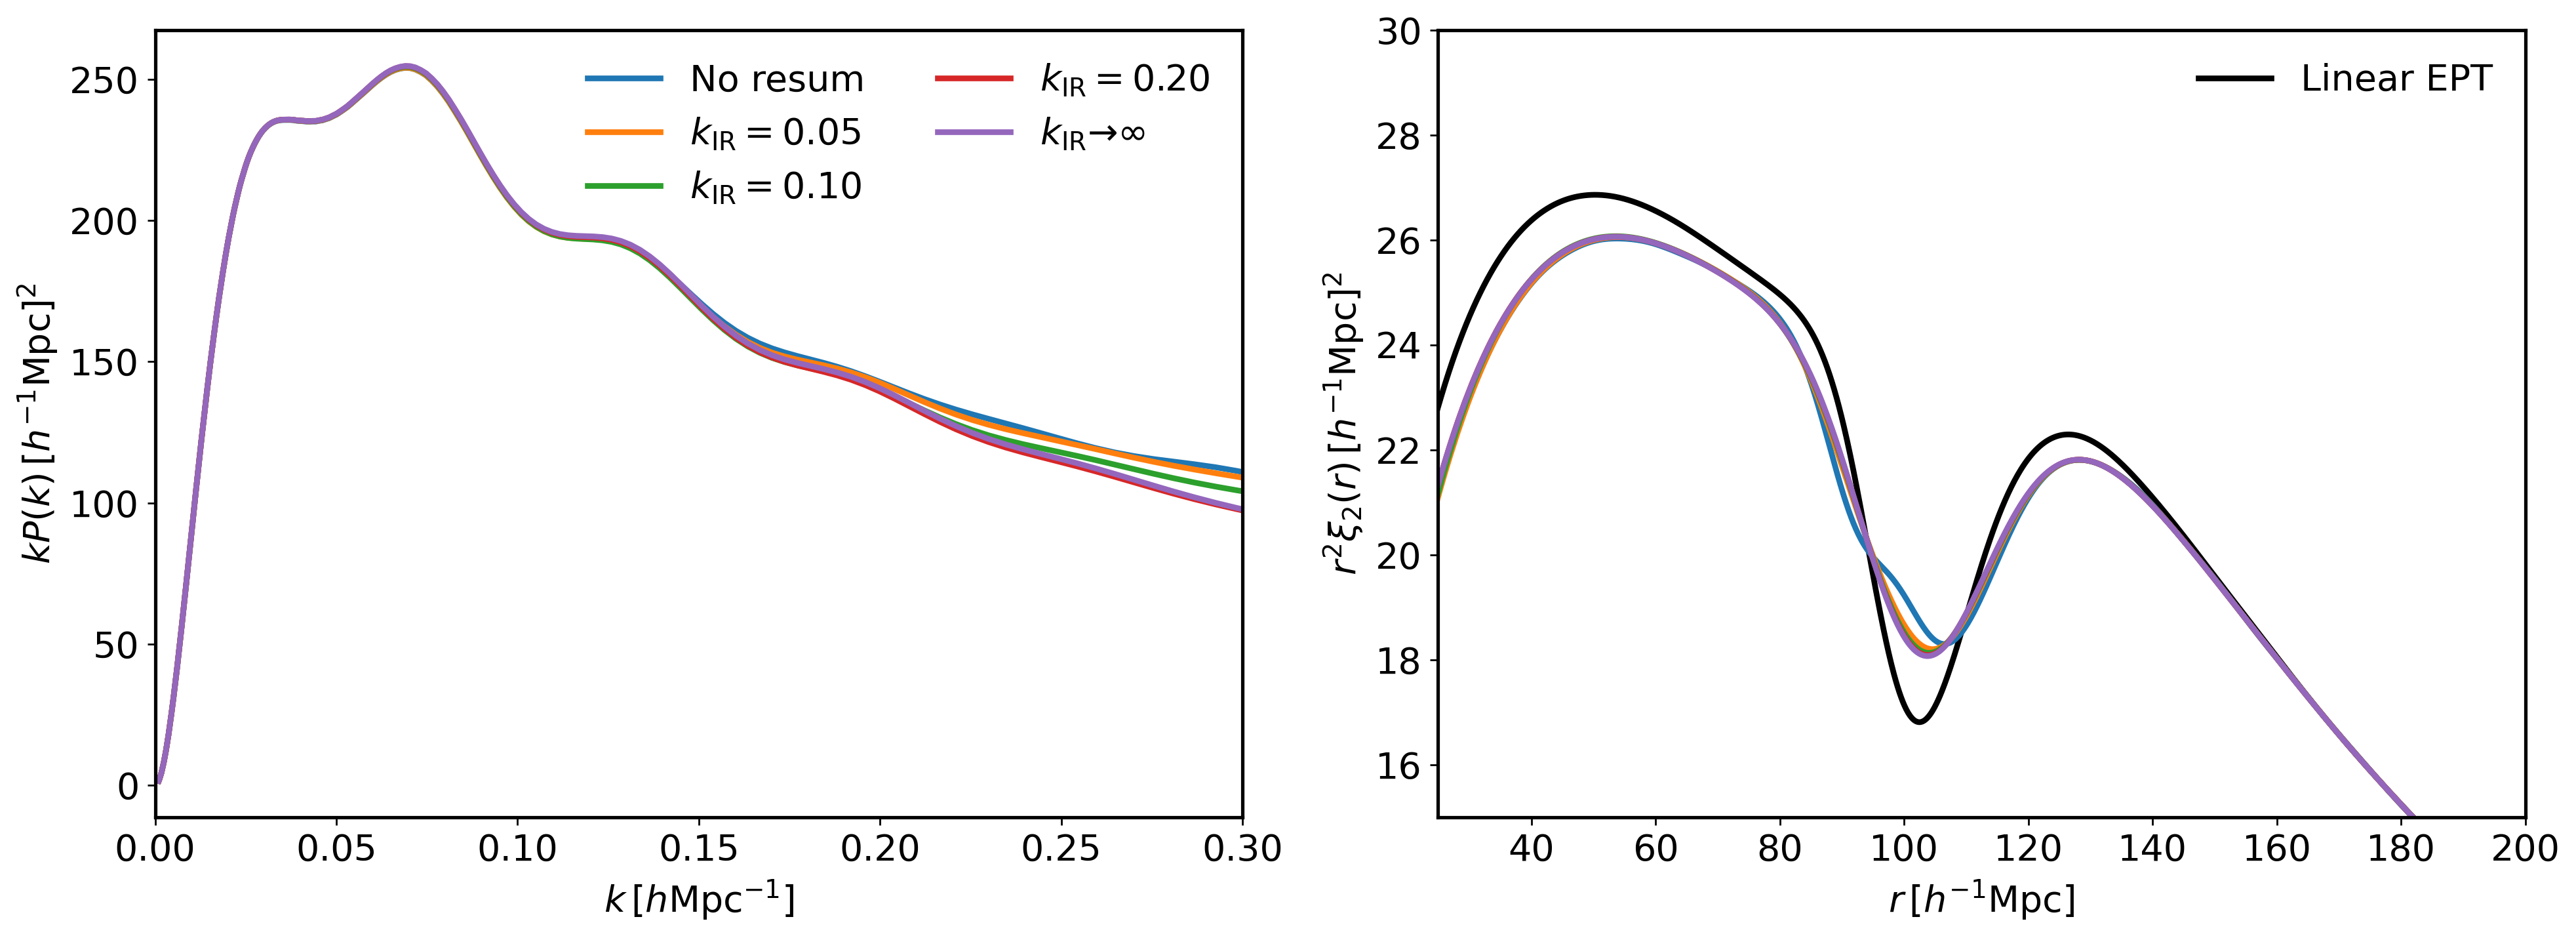

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(16, 6), dpi=250)

ax[1].plot(r, 2/3 * r**2 * xi2, color='k', label='Linear EPT')

m0lptvec = np.zeros(shape=(5, 400))

cvec = plt.get_cmap('tab10')(np.linspace(0, 0.999, 10))


for n, kir in enumerate([0.0001, 0.05, 0.1, 0.2, None]):

    if kir is None:
        label=r'$k_{\rm IR}\to \infty$'
    elif kir==0.0001:
        label=r'No resum'
    else:
        label = r'$k_{\rm IR} = %.2f$'%kir
        
    lpt = DensityShapeCorrelators(klin, plin, kIR=kir, one_loop=True, N=4000)    
    
    lpt.make_gdtable(kmax=3, nk=400)
    gpred = lpt.pktable_gd[:,1]
    m0lptvec[n] = gpred
    
    
    ax[0].plot(ks, ks*m0lptvec[n], color=cvec[n], label=label)
    
    #Transform the prediction
    r, xi2resum = sph.sph(2, loginterp(ks, m0lptvec[n])(klin))
    ax[1].plot(r, r**2 * xi2resum)

ax[0].set_xlim(0, 0.3)
ax[1].set_xlim(25, 200)

ax[1].set_ylim(15, 30)
ax[0].legend(framealpha=False, ncol=2)
# ax[0].set_xlabel()
ax[1].legend(framealpha=False)
ax[0].set_xlabel(r'$k\, [h {\rm Mpc}^{-1}]$')
ax[1].set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$')
ax[0].set_ylabel(r'$k P(k)\, [h^{-1} {\rm Mpc}]^2$')
ax[1].set_ylabel(r'$r^2 \xi_{2} (r)\,[h^{-1}{\rm Mpc}]^2$')
fig.tight_layout()
fig.savefig('baodip.pdf', format='pdf')

# Generate Figure 3

Density-shape correlators for non-matter scalar fields, now. 

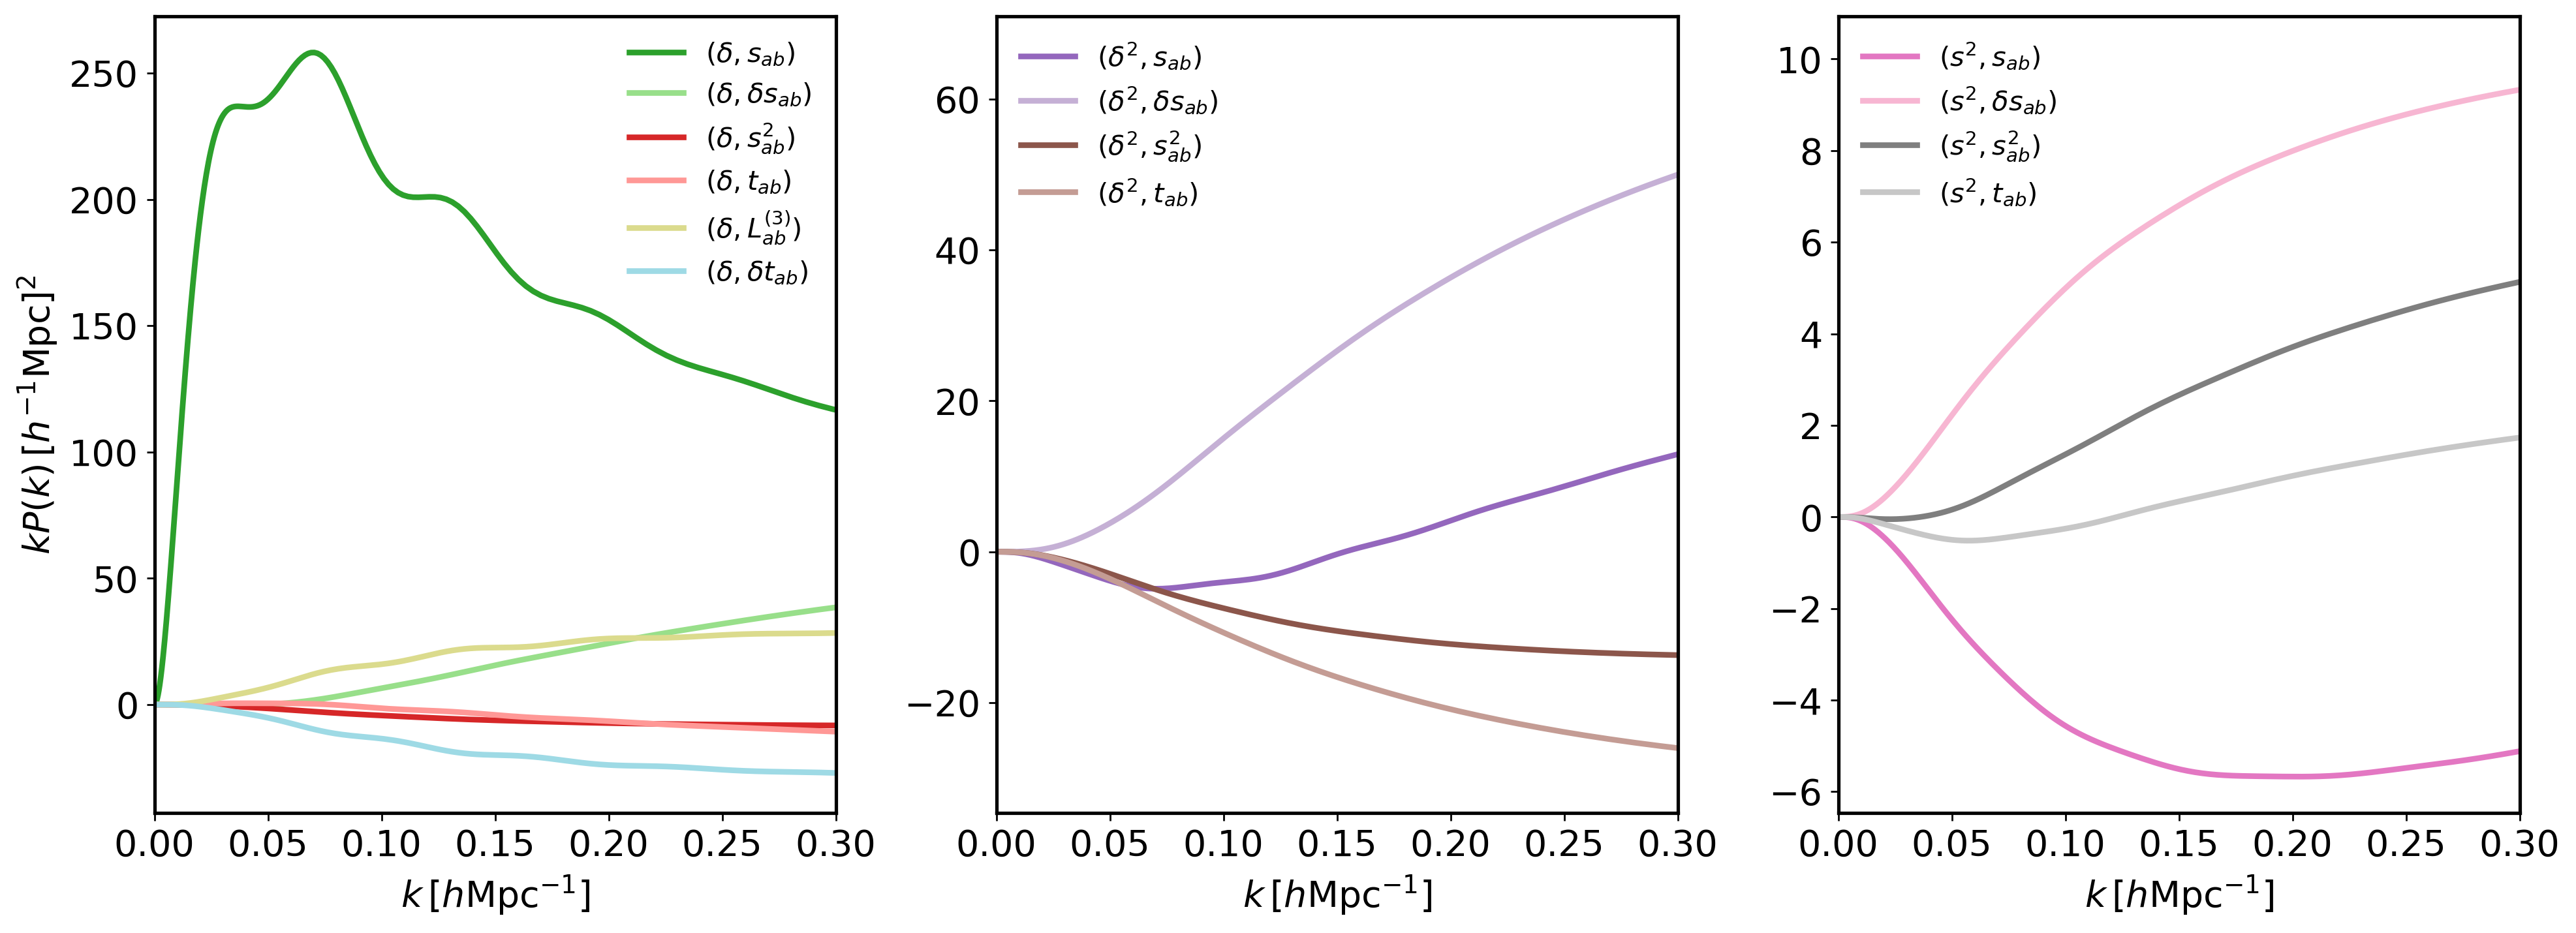

In [6]:
colors = plt.get_cmap('tab20')(np.linspace(0, 0.9999, 20))
fig, ax = plt.subplots(dpi=250, nrows=1, ncols=3, figsize=(16, 6), sharex=True, facecolor='w')

#Recompute at fiducial kIR

lpt = DensityShapeCorrelators(klin, plin, kIR=0.2, N=4000)

lpt.make_gdtable(nk=400)

labelvec = [
    r'$(1, s_{ab})$', 
    r'$(1, \delta s_{ab})$', 
    r'$(1, s^2_{ab})$', 
    r'$(1, L^{(2)}_{ab})$', 
    r'$(\delta, s_{ab})$', 
    r'$(\delta, \delta s_{ab})$', 
    r'$(\delta , s^2_{ab})$',
    r'$(\delta, t_{ab})$', 
    r'$(\delta^2, s_{ab})$', 
    r'$(\delta^2, \delta s_{ab})$', 
    r'$(\delta^2, s^2_{ab})$', 
    r'$(\delta^2, t_{ab})$', 
    r'$(s^2, s_{ab})$', 
    r'$(s^2, \delta s_{ab})$', 
    r'$(s^2, s^2_{ab})$', 
    r'$(s^2, t_{ab})$',     
    r'$(1, L^{(3)}_{ab})$', 
    r'$(\delta, L^{(3)}_{ab})$', 
    r'$(1, \delta t_{ab})$', 
    r'$(\delta, \delta t_{ab})$'
]
for i in range(20):
    
    if i <= 3 or i == 16 or i == 18: 
        pass
    if (i >= 4 and i <= 7) or i == 17 or i == 19:
        ax[0].plot(lpt.pktable_gd[:,0], (lpt.pktable_gd[:,0] * lpt.pktable_gd[:,i+1]), color=colors[i], label=labelvec[i])
    if (i >= 8 and i <= 11):
        ax[1].plot(lpt.pktable_gd[:,0], (lpt.pktable_gd[:,0] * lpt.pktable_gd[:,i+1]), color=colors[i], label=labelvec[i])
    if (i >= 12 and i <= 15):
        ax[2].plot(lpt.pktable_gd[:,0], (lpt.pktable_gd[:,0] * lpt.pktable_gd[:,i+1]), color=colors[i], label=labelvec[i])

ax[0].legend(framealpha=False, fontsize=12)
ax[1].legend(framealpha=False, fontsize=12)
ax[2].legend(framealpha=False, fontsize=12)

for i in range(3):
    ax[i].set_xlabel(r'$k\, [h {\rm Mpc}^{-1}]$')
    
ax[0].set_ylabel(r'$k P(k)\, [h^{-1} {\rm Mpc}]^2$')
ax[0].set_xlim(0, 0.3)

fig.tight_layout()
fig.savefig('dens-shape_pk.pdf', format='pdf', dpi=150)

Now... Onto shape-shape figures. 

# Figure 4

In [7]:
from spinosaurus.shape_shape_correlators_fftw import ShapeShapeCorrelators
from spinosaurus.za_shapeshape import ShapeShapeCorrelators as ZAcorr

lpt = ShapeShapeCorrelators(klin, plin, kIR=0.2, N=4000)


ggtable0 = lpt.make_ggtable(m=0, kmax=0.3, nk=100)

ggtable1 = lpt.make_ggtable(m=1, kmax=0.3, nk=100)

ggtable2 = lpt.make_ggtable(m=2, kmax=0.3, nk=100)

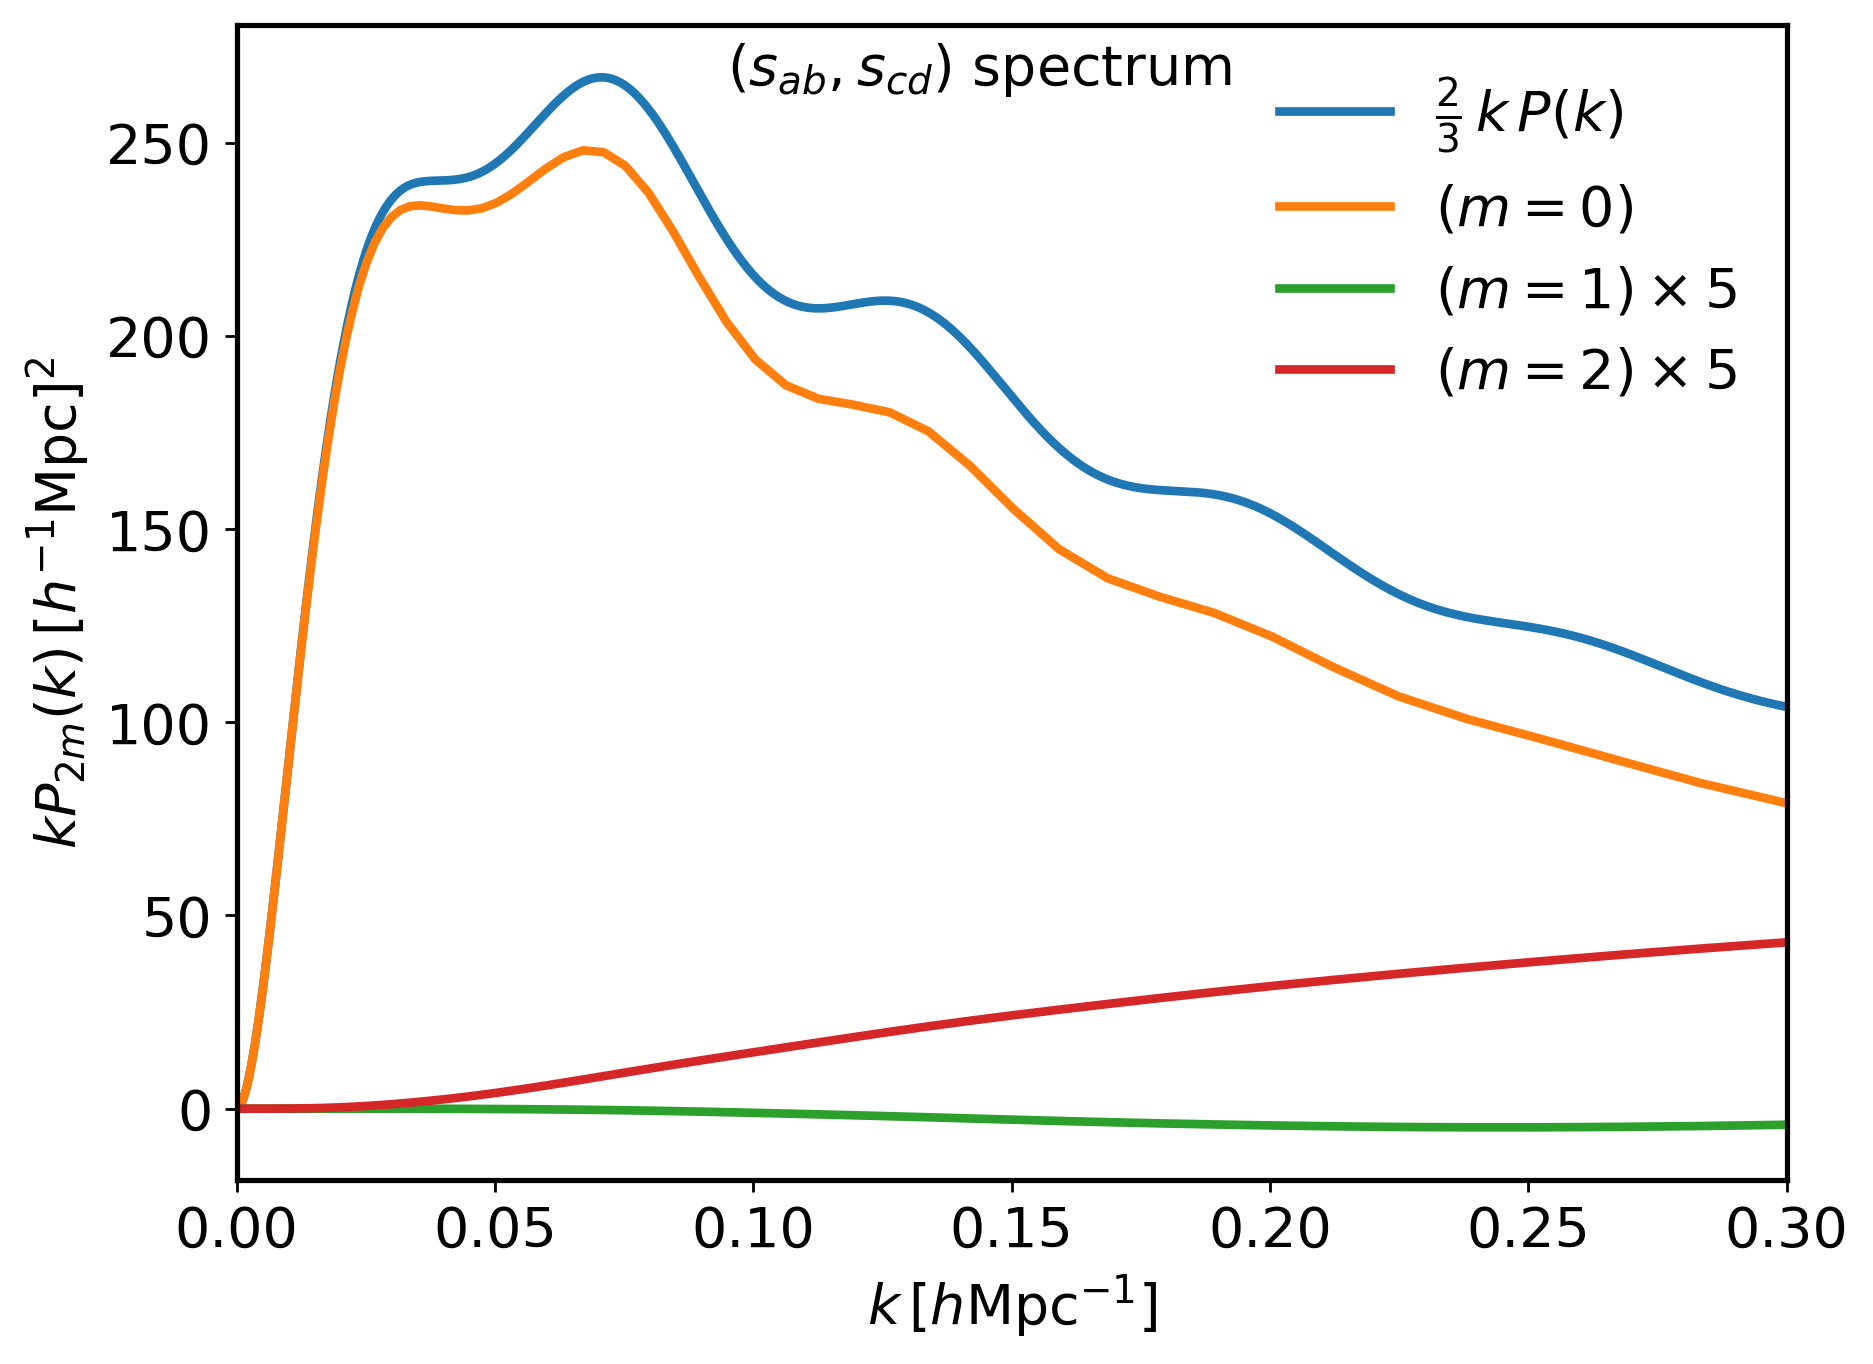

In [8]:
i = 1
ks = ggtable0[:,0]

cvec = plt.get_cmap('tab20')(np.linspace(0, 0.999, 20))

labelvec = [r'$(s,s)$', r'$(s,\delta s)$',r'$(s,s^2)$', r'$(s,L^{(2)})$', r'$(\delta s,\delta s)$', 
           r'$(\delta s,s^2)$', r'$(\delta s,L^{(2)})$', r'$(s^2,s^2)$', r'$(s^2, L^{(2)})$', r'$(s,s^3)$', r'$(s,\delta t)$', r'$(s, \nabla^2 s)$']
plt.figure(dpi=250, facecolor='w')

plt.plot(klin,  2/3 * klin * plin, label=r'$\frac{2}{3}\,k\, P(k)$')

plt.plot(ks, ks*ggtable0[:,i],  label=r'$(m=0)$')

plt.plot(ks, 5*ks*ggtable1[:,i],  label=r'$(m=1)\times 5$')
plt.plot(ks, 5*ks*ggtable2[:,i],  label=r'$(m=2)\times 5$')

plt.xlim(0, 0.3)
plt.xlabel(r'$k\,[h{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k P_{2m}(k)\, [h^{-1} {\rm Mpc}]^2$')
# plt.ylim(-25, 300)

plt.text(0.095, 265, r'$(s_{ab}, s_{cd})$ spectrum')
plt.legend(framealpha=False)

plt.savefig('ss_advect_helicty.pdf')

# Figure 5

Now we plot all of those other predictions.

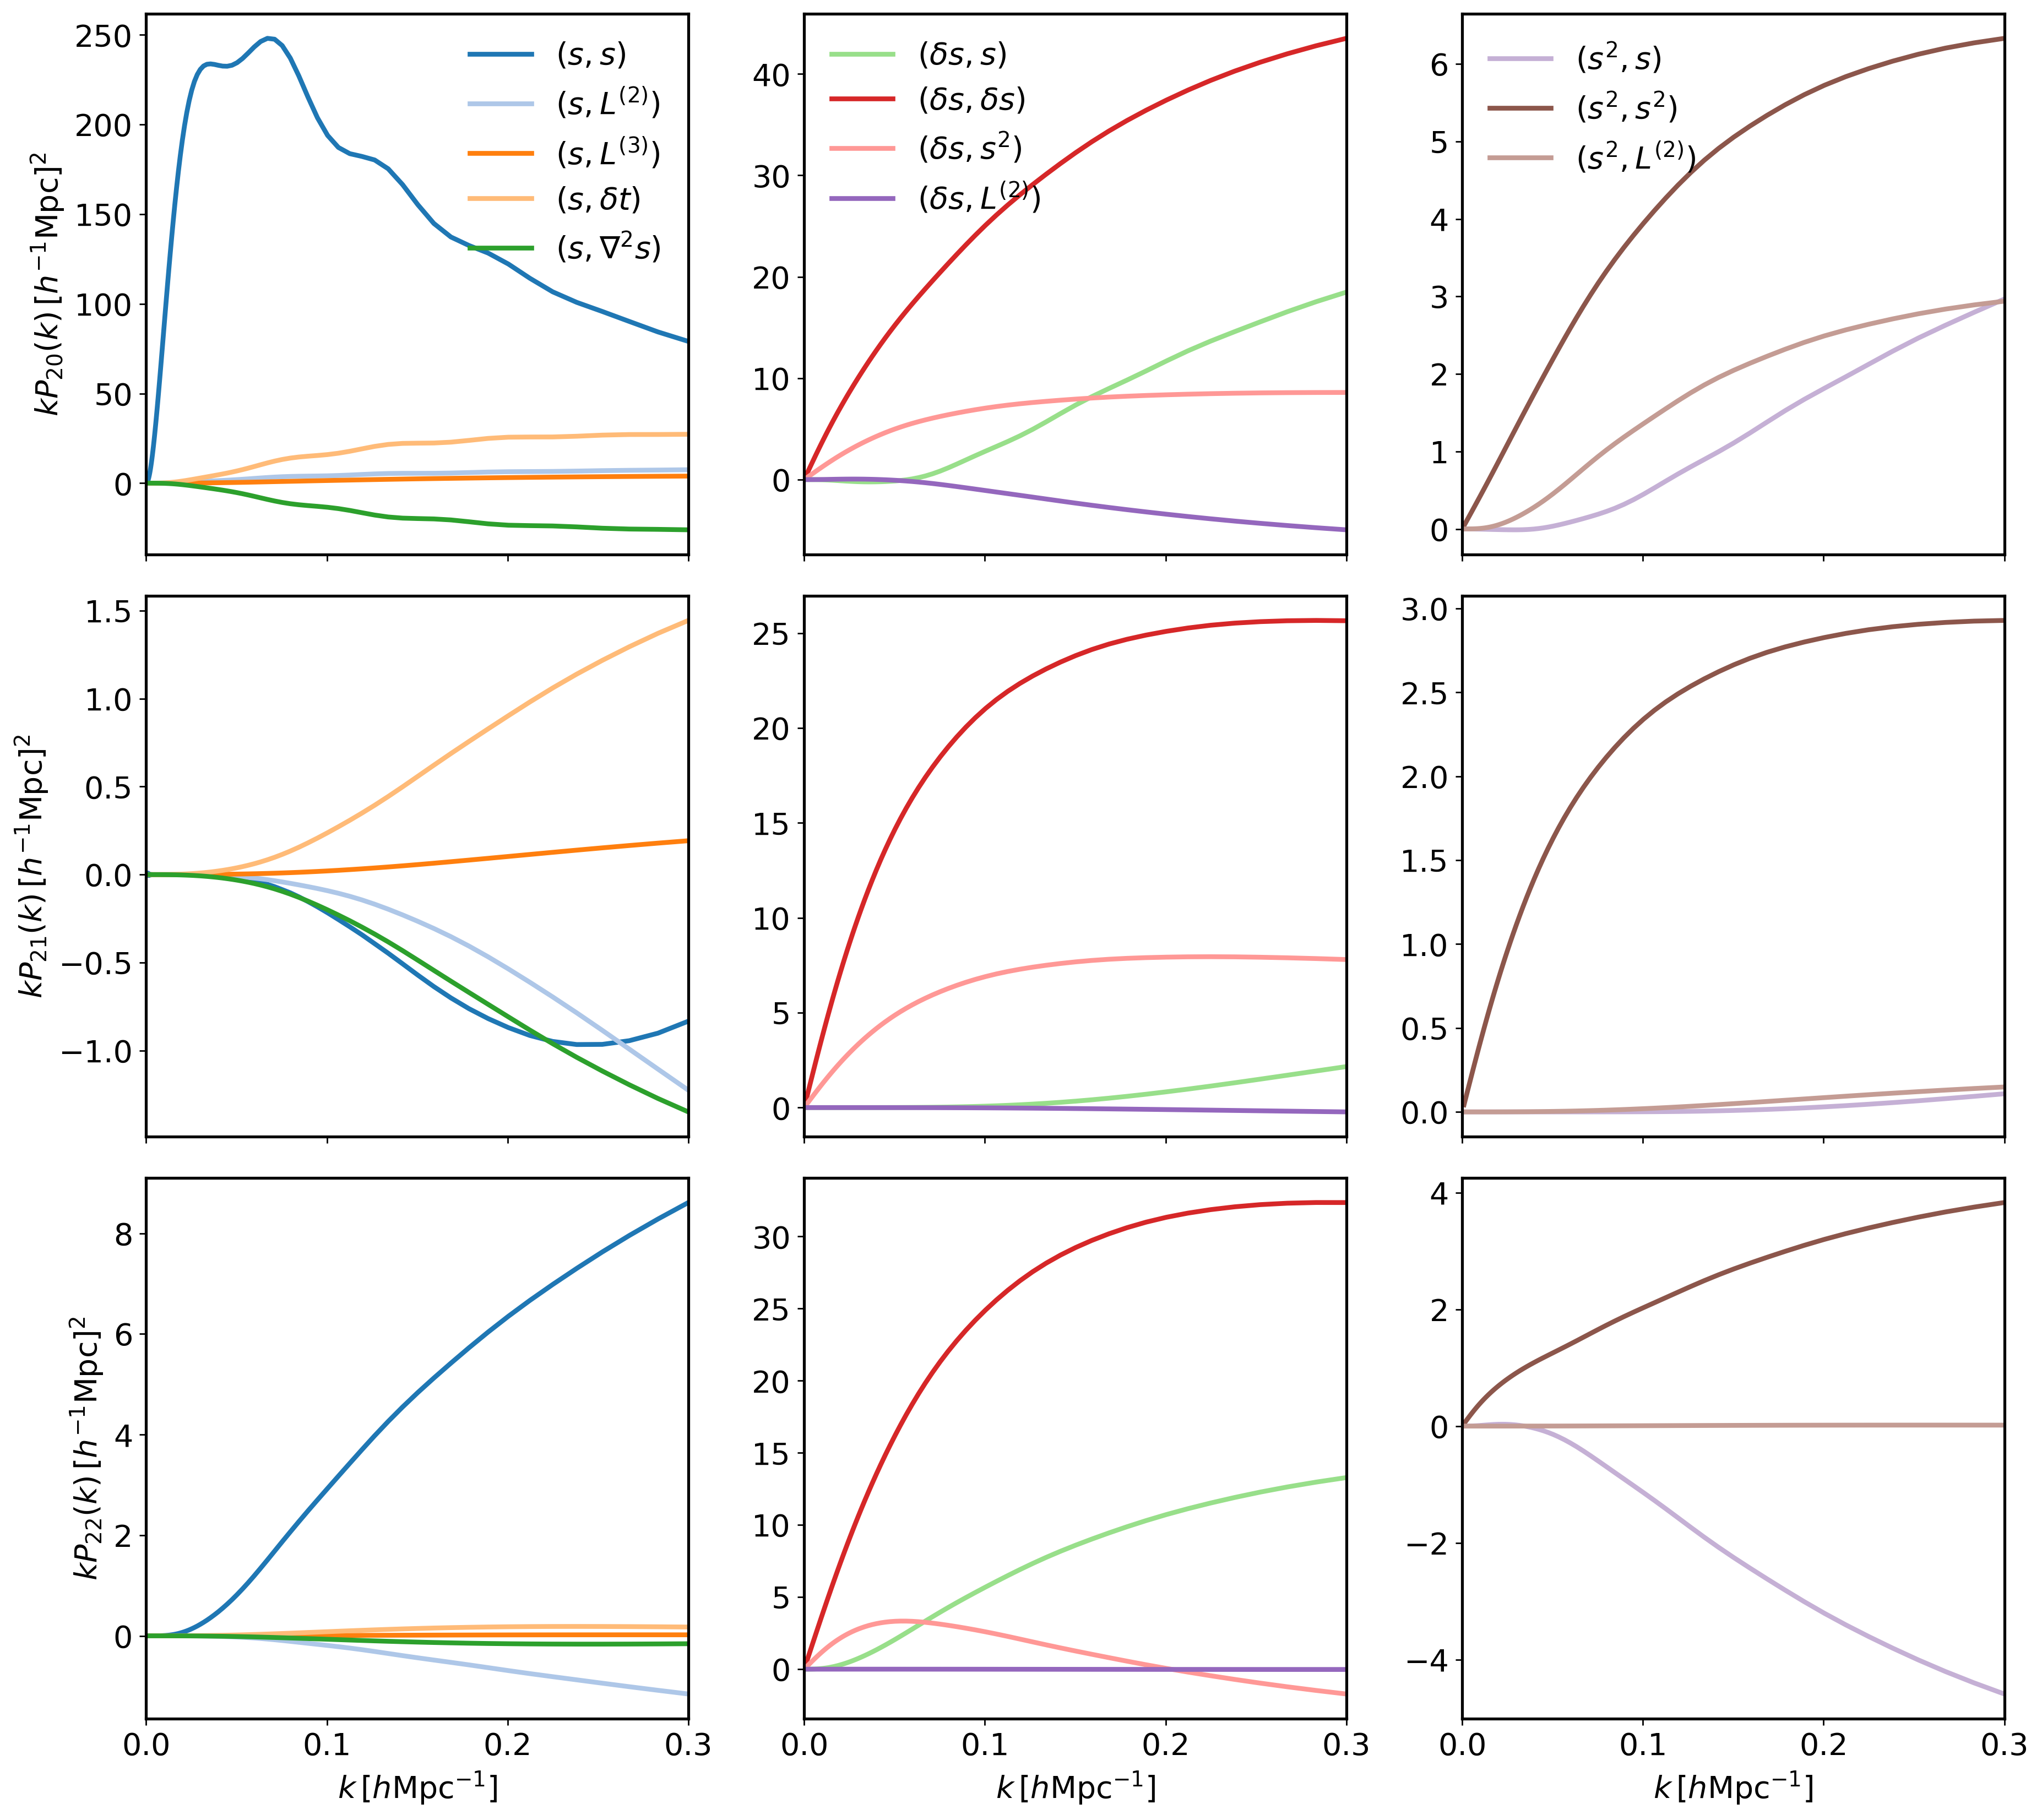

In [9]:
ks = ggtable0[:,0]

i = 1

cvec = plt.get_cmap('tab20')(np.linspace(0, 0.999, 20))

labelvec = [r'$(s,s)$', r'$(\delta s, s)$',r'$(s^2, s)$', r'$(s,L^{(2)})$', r'$(\delta s,\delta s)$', 
           r'$(\delta s,s^2)$', r'$(\delta s,L^{(2)})$', r'$(s^2,s^2)$', r'$(s^2, L^{(2)})$', r'$(s,L^{(3)})$', r'$(s,\delta t)$', r'$(s, \nabla^2 s)$']
fig, ax = plt.subplots(figsize=(15, 13.5), facecolor='w', nrows=3, ncols=3, dpi=250, sharex=True)

mvec = [ggtable0, ggtable1, ggtable2]

for m in range(3):
    cidx = 0

    for i in [0,  3, 9, 10, 11]:
        ax[m,0].plot(ks, ks*mvec[m][:,i+1], color=cvec[cidx], label=labelvec[i])
        cidx +=1
    for i in [1, 4, 5, 6]:
        ax[m,1].plot(ks, ks*mvec[m][:,i+1], color=cvec[cidx], label=labelvec[i])

        cidx +=1

    for i in [2, 7, 8]:
        ax[m,2].plot(ks, ks*mvec[m][:,i+1], color=cvec[cidx], label=labelvec[i])

        cidx +=1
    ax[m,0].set_xlim(0, 0.3)
    if m == 0:
        for i in range(3):
            ax[m, i].legend(framealpha=False)
            ax[2, i].set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$')

    ax[m, 0].set_ylabel(r'$k P_{2%d}(k)\, [h^{-1} {\rm Mpc}]^2$'%m)
fig.tight_layout()
fig.savefig('shapeshapeplot.pdf')

# Now we fit to data! Onto figs 6 and 7

## Load data

In [10]:
def load_spin_data(M1, M2, dk = 0.005, Vobs = 1.5**3 * 1e9):

    kdats = np.loadtxt('../data/power_RS_reduced_%s_%s_z0.51_%s.dat'%(M1,M2,20))[:,0]
    Pshot = np.loadtxt('../data/shot_RS_reduced_%s_%s_z0.51.dat'%(M1,M2))[()]

    spectra = {}
    errs = {}

    helicities = ['20', '21m', '21p', '22m', '22p']

    for helicity in helicities:
        spectra[helicity] = np.loadtxt('../data/power_RS_reduced_%s_%s_z0.51_%s.dat'%(M1,M2,helicity))[:,1] - 2*Pshot
        errs[helicity] = np.loadtxt('../data/power_RS_reduced_%s_%s_z0.51_%s.dat'%(M1,M2,helicity))[:,2]
        
    spectra['21'] = (spectra['21p'] + spectra['21m'])/2
    errs['21'] = (errs['21p'] + errs['21m'])/2/np.sqrt(2)

    spectra['22'] = (spectra['22p'] + spectra['22m'])/2
    errs['22'] = (errs['22p'] + errs['22m'])/2/np.sqrt(2)

    dvec = np.concatenate( (spectra['20'],spectra['21'],spectra['22']))

    Nk =  8 * Vobs * kdats**2 * dk / (2*np.pi**2)
    cov = 2 * np.diag( (2*Pshot + np.concatenate((spectra['20'], spectra['21'], spectra['22']) ) )**2 )
    cov /= np.concatenate( (Nk, 2*Nk, 2*Nk))
    cinv = np.linalg.inv(cov)
    dcov = np.diag(cov)
    
    return kdats, spectra, errs, dvec, dcov, Pshot

klin, plin = np.loadtxt('../data/power_lin.dat', unpack=True); plin *= Dz**2

In [11]:
M1, M2 = '1e12', '3.16e12'

#M1, M2 = '3.16e12', '1e13'

M1, M2 = '1e13', '3.16e13'

kdats, spectra, errs, dvec, dcov, Pshot = load_spin_data(M1,M2)

In [12]:
lpt = ShapeShapeCorrelators(klin, plin, kIR=0.2, one_loop=True, N=2000, jn=15)

pktable0 = lpt.make_ggtable(0,kmin=5e-3, kmax=0.31, nk=200)
pktable1 = lpt.make_ggtable(1,kmin=5e-3, kmax=0.31, nk=200)
pktable2 = lpt.make_ggtable(2,kmin=5e-3, kmax=0.31, nk=200)

Define some curve-fitting functions (This will be unified once we fix the k2 shot noise aspec)

In [13]:
def curve_func(k, c_s, c_ds, c_s2, c_L2, c_3, c_dt, alpha_s1, sn, sn21, sn22):
        
    bvec = [c_s, c_ds, c_s2, c_L2, c_3, c_dt, alpha_s1, sn, sn21, sn22]
    
    P0 = interp1d(*lpt.combine_bias_terms_shape_shape(0, bvec[:-3], bvec[:-3], Pshot=bvec[-3], sn21=bvec[-2], sn22=bvec[-1]),kind='cubic')(k)
    P1 = interp1d(*lpt.combine_bias_terms_shape_shape(1, bvec[:-3], bvec[:-3],  Pshot=bvec[-3], sn21=bvec[-2], sn22=bvec[-1]),kind='cubic')(k)
    P2 = interp1d(*lpt.combine_bias_terms_shape_shape(2, bvec[:-3], bvec[:-3],  Pshot=bvec[-3], sn21=bvec[-2], sn22=bvec[-1]),kind='cubic')(k)

    
    return np.concatenate( (P0, P1, P2) )

def curve_func_nok2(k, c_s, c_ds, c_s2, c_L2, c_3, c_dt, alpha_s1, sn):
        
    bvec = [c_s, c_ds, c_s2, c_L2, c_3, c_dt, alpha_s1, sn, 0, 0]
    
    P0 = interp1d(*lpt.combine_bias_terms_shape_shape(0, bvec[:-3], bvec[:-3],  Pshot=bvec[-3], sn21=bvec[-2], sn22=bvec[-1]),kind='cubic')(k)
    P1 = interp1d(*lpt.combine_bias_terms_shape_shape(1, bvec[:-3], bvec[:-3],  Pshot=bvec[-3], sn21=bvec[-2], sn22=bvec[-1]),kind='cubic')(k)
    P2 = interp1d(*lpt.combine_bias_terms_shape_shape(2, bvec[:-3], bvec[:-3],  Pshot=bvec[-3], sn21=bvec[-2], sn22=bvec[-1]),kind='cubic')(k)
    
    return np.concatenate( (P0, P1, P2) )

def curve_func_local(k, c_s, c_ds,  alpha_s1, sn, sn21, sn22):
        
    bvec = [c_s, c_ds, 0, 0, 0, 0, alpha_s1, sn, sn21, sn22]
    
    P0 = interp1d(*lpt.combine_bias_terms_shape_shape(0, bvec[:-3], bvec[:-3],  Pshot=bvec[-3], sn21=bvec[-2], sn22=bvec[-1]),kind='cubic')(k)
    P1 = interp1d(*lpt.combine_bias_terms_shape_shape(1, bvec[:-3], bvec[:-3],  Pshot=bvec[-3], sn21=bvec[-2], sn22=bvec[-1]),kind='cubic')(k)
    P2 = interp1d(*lpt.combine_bias_terms_shape_shape(2, bvec[:-3], bvec[:-3],  Pshot=bvec[-3], sn21=bvec[-2], sn22=bvec[-1]),kind='cubic')(k)
    
    return np.concatenate( (P0, P1, P2) )

## To generate the NLA fits we use halofit off of a surrogate of the normal cosmology... Damn you CCL (and the currently broken CLASS installation)

In [14]:
import pyccl as ccl

###Parameters from Planck 2018, they don't include Omega_nu into Omega_m in CCL... 
#
# Omega_nu ~ \sum_mnu mnu / 93.04 
#

fb =  0.02230 /(0.1188+ 0.02230)

#Subtract Omega_nu or else CCL disagrees.
Om = 0.3089 - (0.06/93.04)/0.6774**2


cosmo = ccl.Cosmology(Omega_c=(1-fb)*Om, Omega_b=fb*Om,
    h=0.6774,
    n_s=0.9667,
    sigma8=0.8159, transfer_function='boltzmann_camb', m_nu=0.06, m_nu_type='single', Neff=3.046)

In [15]:
klin
pkl = ccl.linear_matter_power(cosmo, klin*cosmo['h'], 1./(1+z))*cosmo['h']**3


pknl = ccl.nonlin_matter_power(cosmo, klin*cosmo['h'], 1./(1+z))*cosmo['h']**3

/home/nick/Libraries/miniconda3/envs/cosmo/lib/python3.8/site-packages/pyccl/core.py:675: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(


[]

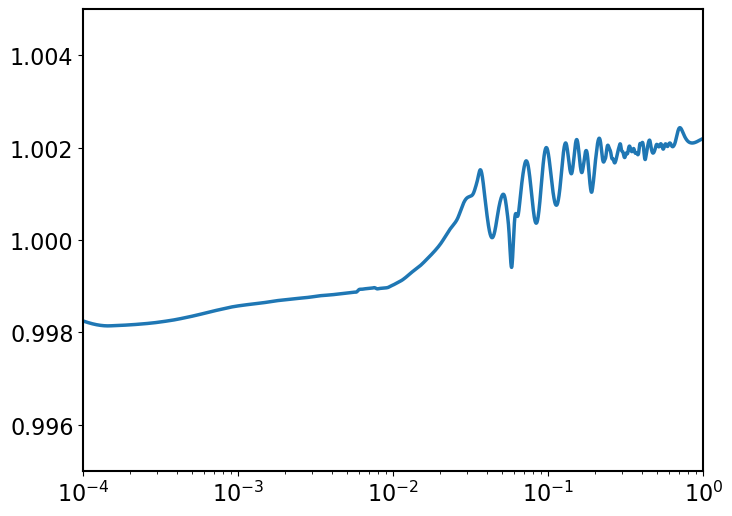

In [16]:
plt.plot(klin, pkl/plin)
plt.xlim(1e-4, 1)
# plt.ylim(0.99, 1.01)
plt.ylim(0.995, 1.005)
plt.semilogx()

Good enough agreement for us. From this halofit prediction we generate "NLA" curves to fit with:

In [17]:
def curve_func_nla(k, c_s):
        
    #No noise because NLA assumes noise subtraction. 
    
    
    P0 = interp1d(klin, c_s*pknl)(k)
    P1 = np.zeros_like(P0)
    P2 = np.zeros_like(P0)
    


    return np.concatenate((P0, P1, P2))


First we try a fit to kmax=0.3 like with LPT:

0 1e12 3.16e12
0.0014818470773521983
0.0014818470773521983
1 1e13 3.16e13
0.0052443238865934215
0.0052443238865934215


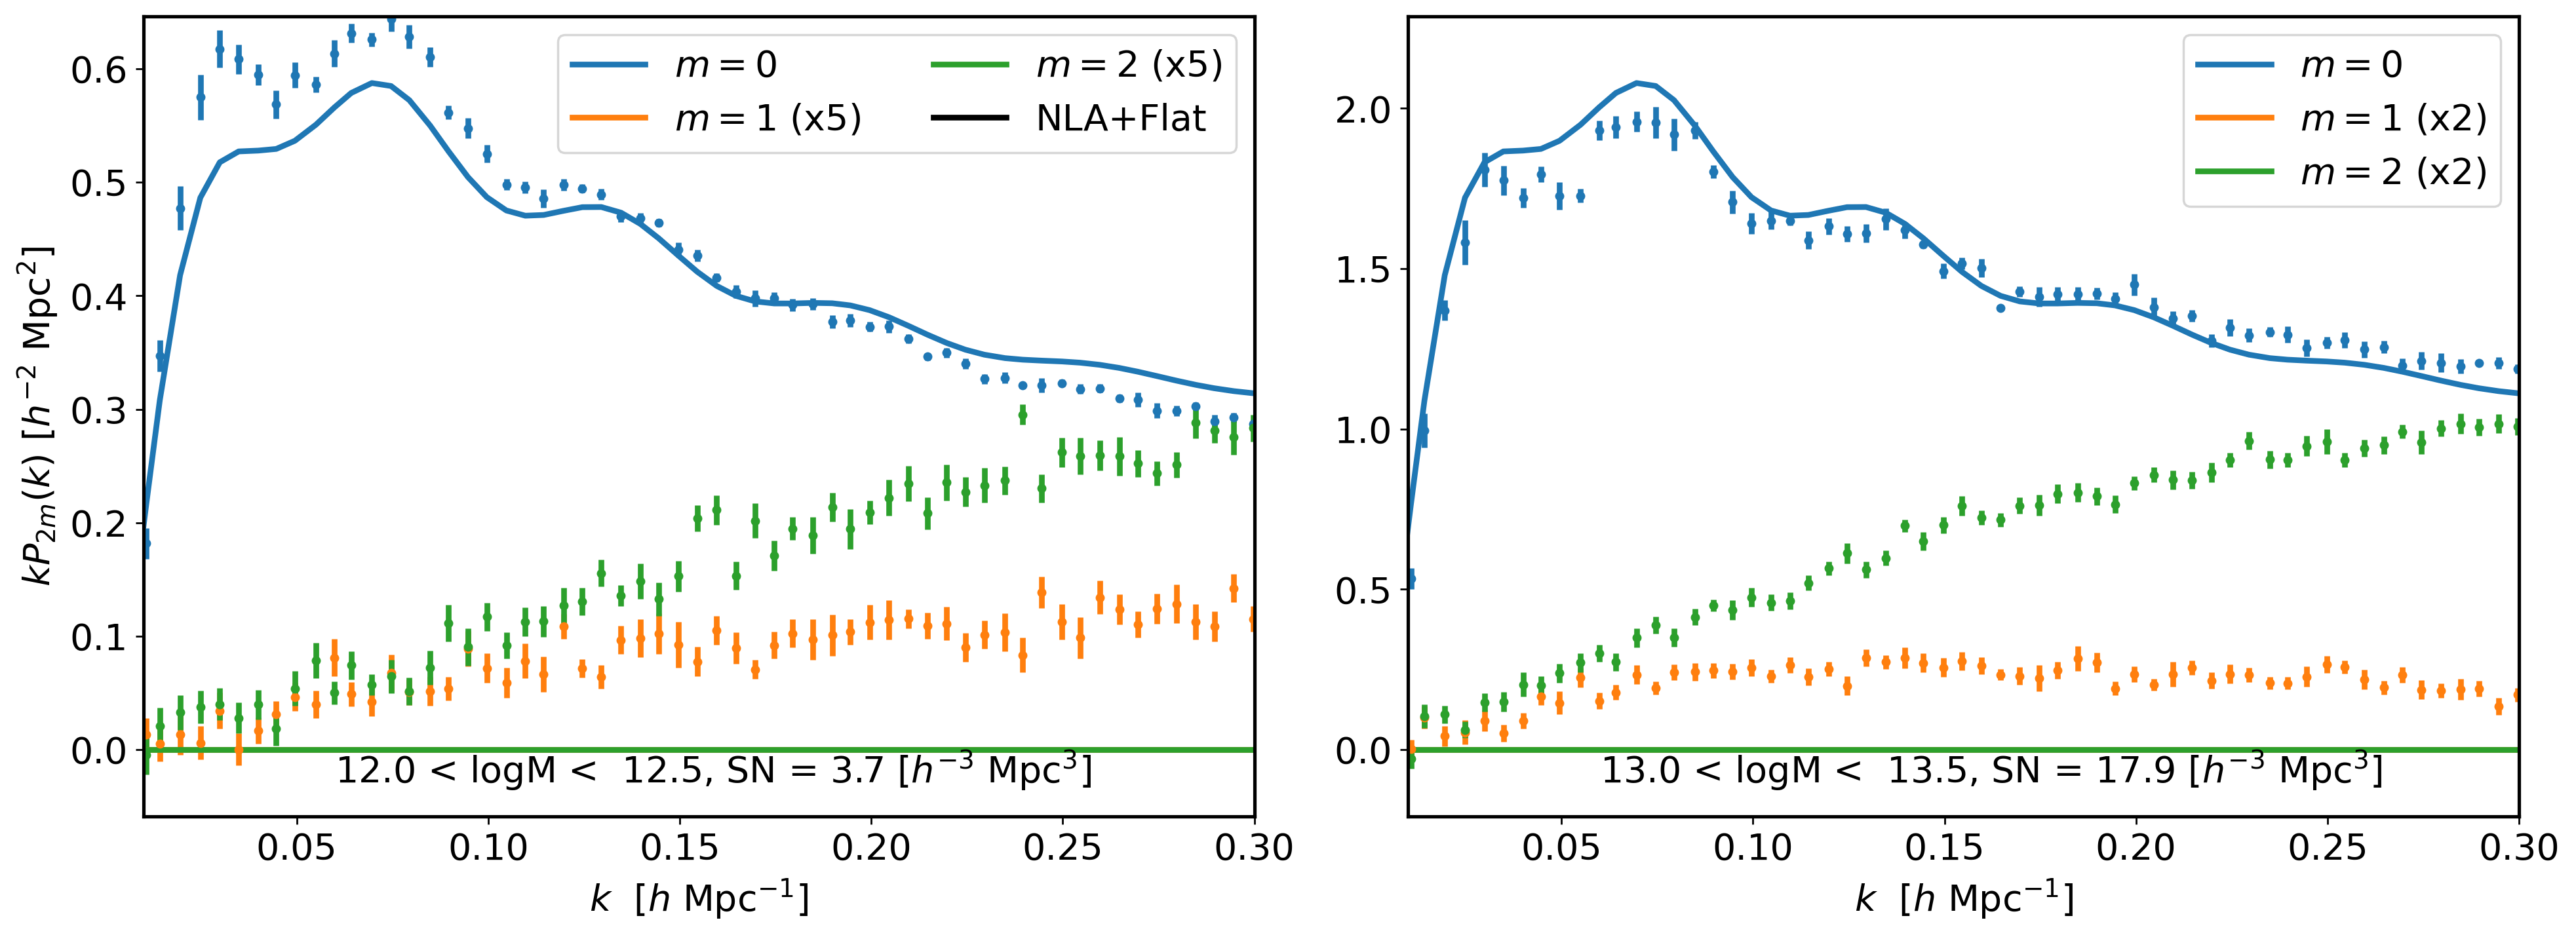

In [18]:
mfacs = [5,2]

plt.figure(dpi=250, figsize=(16, 6))

for ii, (M1, M2) in enumerate([ ('1e12', '3.16e12'), ('1e13', '3.16e13') ]):

    print(ii, M1,M2)
    
    m1fac = mfacs[ii]
    m2fac = mfacs[ii]
    
    kdats, spectra, errs, dvec, dcov, Pshot = load_spin_data(M1,M2)
    
    iis = (kdats > 0.02) * (kdats < 0.3)

    xdat = kdats[iis]
    ydat = np.concatenate((spectra['20'][iis], spectra['21'][iis], spectra['22'][iis]))
    sigmas = np.sqrt(dcov)[np.concatenate((iis,iis,iis))]

    res = curve_fit(curve_func_nla, xdat, ydat, sigma=sigmas)
    print(res[0][0])

    ps = curve_func_nla(kdats, *res[0])
    p0 = ps[:60]
    p1 = ps[60:120]
    p2 = ps[120:]
    print(res[0][0])
    
    plt.subplot(1,2,ii+1)

    plt.errorbar(kdats, kdats * spectra['20'], yerr=kdats*errs['20'],fmt='.',c='C0' )
    plt.errorbar(kdats, m1fac * kdats * spectra['21'], yerr=m1fac * kdats*errs['21'], fmt='.',c='C1' )
    plt.errorbar(kdats, m2fac * kdats * spectra['22'], yerr=m2fac * kdats*errs['22'], fmt='.',c='C2' )

    plt.plot(kdats, kdats * p0,label=r'$m=0$')
    plt.plot(kdats, m1fac * kdats * p1,label=r'$m=1$ (x%d)'%(m1fac))
    plt.plot(kdats, m2fac * kdats * p2,label=r'$m=2$ (x%d)'%(m2fac))

    plt.xlim(0.01,0.3)
    plt.ylim(-0.1 * np.max(kdats*p0), 1.1 * np.max(kdats*p0))
    
    plt.text(0.06, -0.05 * np.max(kdats*p0), r'%.1f < logM <  %.1f, SN = %.1f [$h^{-3}$ Mpc$^3$]'%(np.log10(float(M1)),np.log10(float(M2)),Pshot))

    plt.xlabel(r'$k$  [$h$ Mpc$^{-1}$]')
    if ii==0:
        plt.ylabel(r'$k P_{2m}(k)$ [$h^{-2}$ Mpc$^2$]')
    
    if ii==0:
        plt.plot(0,0,'k',label='NLA+Flat')

        plt.legend(loc='upper right',ncol=2)
    else:
        plt.legend(loc='upper right')
    
plt.tight_layout()

Oh... Go to kmax=0.1.

0 1e12 3.16e12
0.05015252528092735
0.05015252528092735
0.0016189470796838222
1 1e13 3.16e13
0.0842221248074681
0.0842221248074681
0.004973793749156405


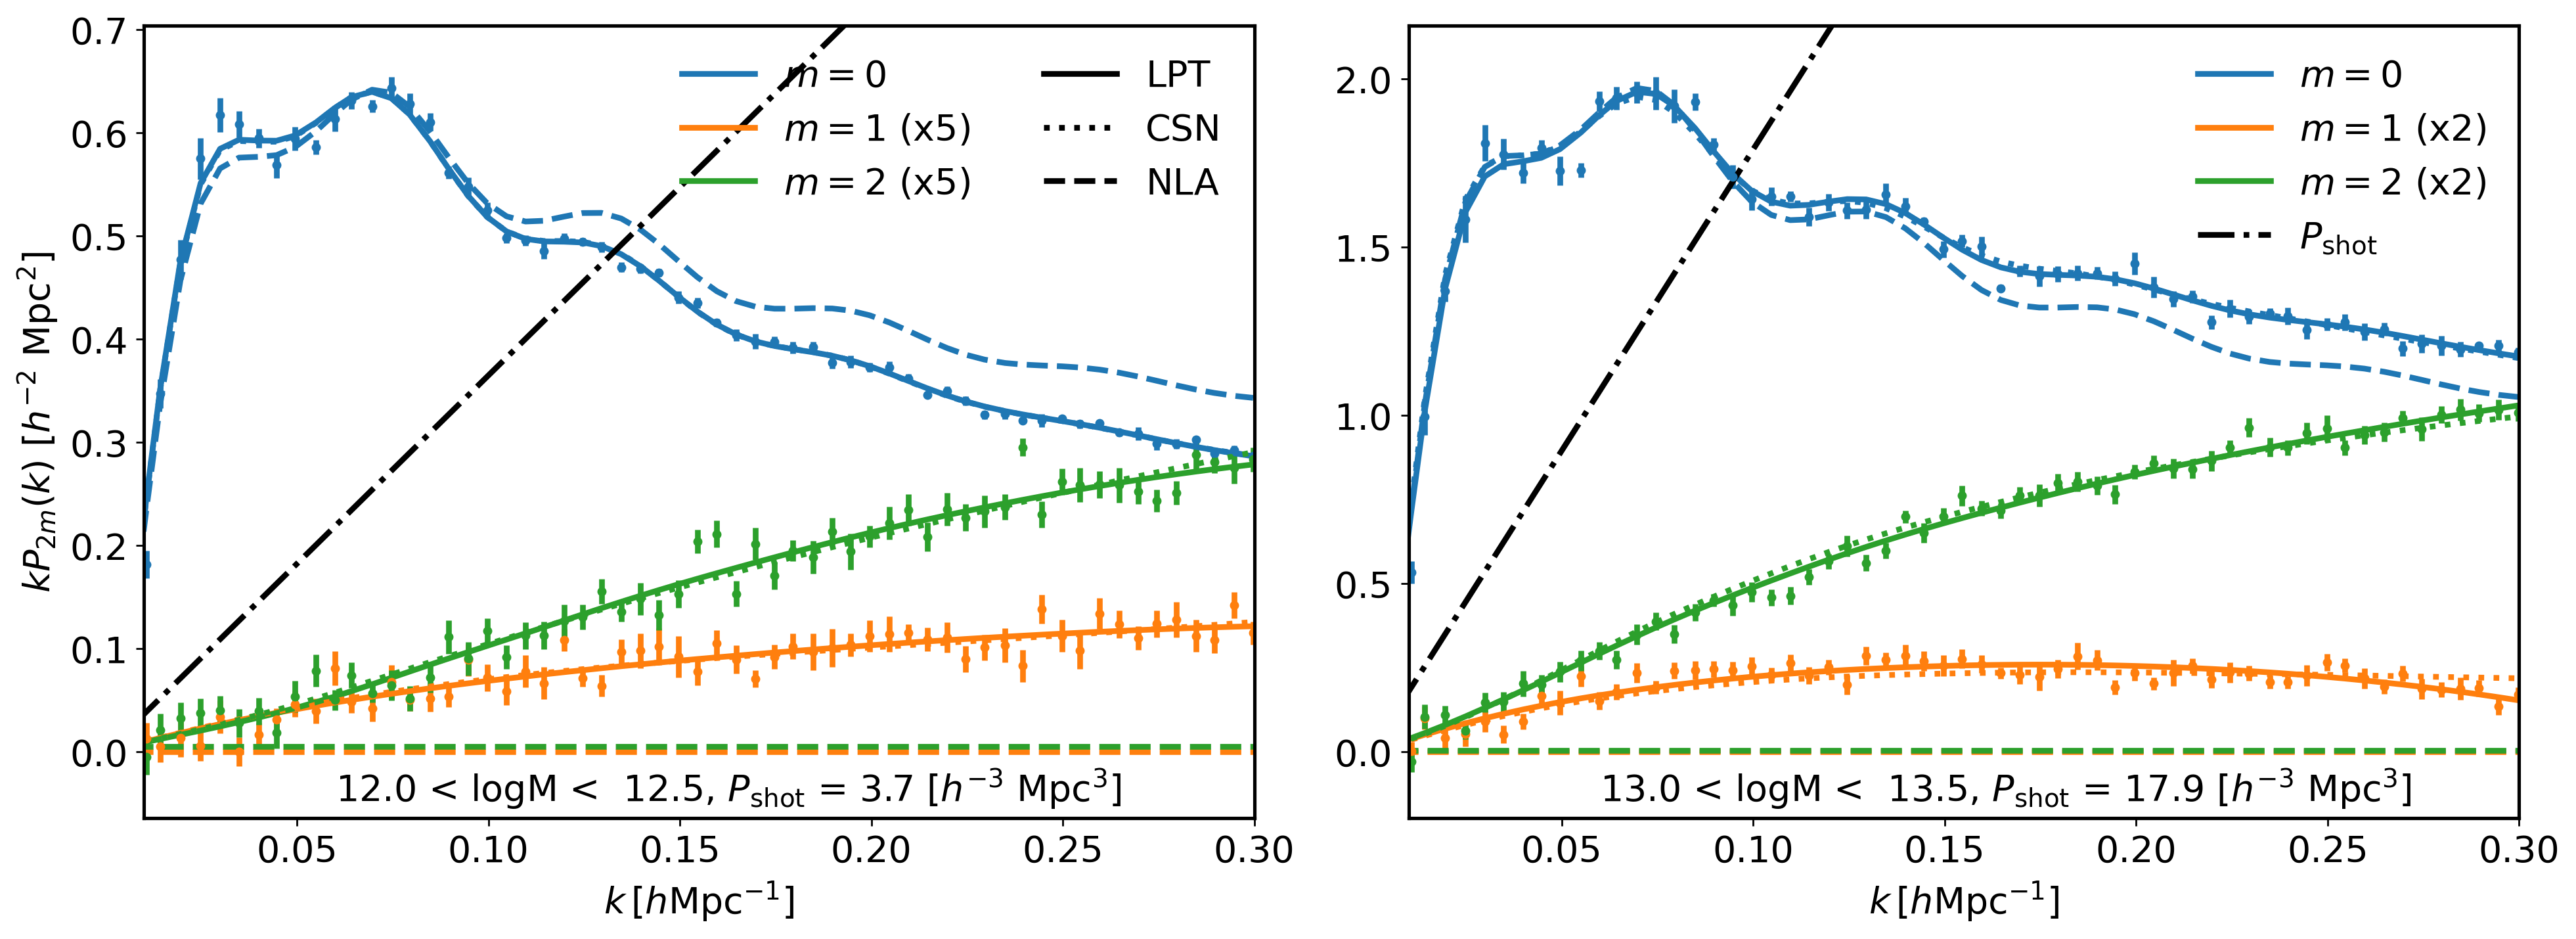

In [19]:
mfacs = [5,2]

plt.figure(dpi=250, figsize=(16, 6))

for ii, (M1, M2) in enumerate([ ('1e12', '3.16e12'), ('1e13', '3.16e13') ]):

    print(ii, M1,M2)
    
    m1fac = mfacs[ii]
    m2fac = mfacs[ii]
    
    kdats, spectra, errs, dvec, dcov, Pshot = load_spin_data(M1,M2)
    
    iis = (kdats > 0.02) * (kdats < 0.3)

    xdat = kdats[iis]
    ydat = np.concatenate( (spectra['20'][iis], spectra['21'][iis], spectra['22'][iis]))
    sigmas = np.sqrt(dcov)[np.concatenate((iis,iis,iis))]

    res = curve_fit(curve_func, xdat, ydat, sigma=sigmas)
    print(res[0][0])

    ps = curve_func(kdats, *res[0])
    p0 = ps[:60]
    p1 = ps[60:120]
    p2 = ps[120:]
    print(res[0][0])

    
    res = curve_fit(curve_func_nok2, xdat, ydat, sigma=sigmas)
    ps = curve_func_nok2(kdats, *res[0])
    p0_nok2 = ps[:60]
    p1_nok2 = ps[60:120]
    p2_nok2 = ps[120:]

    
    
    iis = (kdats > 0.02) * (kdats < 0.1)

    xdat = kdats[iis]
    ydat = np.concatenate( (spectra['20'][iis], spectra['21'][iis], spectra['22'][iis]))
    sigmas = np.sqrt(dcov)[np.concatenate((iis,iis,iis))]
    res = curve_fit(curve_func_nla, xdat, ydat, sigma=sigmas)
    print(*res[0])
    ps = curve_func_nla(kdats, *res[0])
    p0_nla = ps[:60]
    p1_nla = ps[60:120]
    p2_nla = ps[120:]
    
    plt.subplot(1,2,ii+1)

    plt.errorbar(kdats, kdats * spectra['20'], yerr=kdats*errs['20'],fmt='.',c='C0' )
    plt.errorbar(kdats, m1fac * kdats * spectra['21'], yerr=m1fac * kdats*errs['21'], fmt='.',c='C1' )
    plt.errorbar(kdats, m2fac * kdats * spectra['22'], yerr=m2fac * kdats*errs['22'], fmt='.',c='C2' )

    plt.plot(kdats, kdats * p0,label=r'$m=0$')
    plt.plot(kdats, m1fac * kdats * p1,label=r'$m=1$ (x%d)'%(m1fac))
    plt.plot(kdats, m2fac * kdats * p2,label=r'$m=2$ (x%d)'%(m2fac))

    plt.plot(kdats, kdats * p0_nok2,'C0:')
    plt.plot(kdats, m1fac * kdats * p1_nok2,'C1:')
    plt.plot(kdats, m2fac * kdats * p2_nok2,'C2:')
    
    plt.plot(kdats, kdats * p0_nla,'C0--')
    plt.plot(kdats, m1fac * kdats * p1_nla,'C1--')
    plt.plot(kdats, m2fac * (kdats * p2_nla)+ 0.005,'C2--')
    
    plt.plot(kdats, kdats * Pshot, 'k-.')
    
    plt.xlim(0.01,0.3)
    plt.ylim(-0.1 * np.max(kdats*p0), 1.1 * np.max(kdats*p0))
    
    plt.text(0.06, -0.075 * np.max(kdats*p0), r'%.1f < logM <  %.1f, $P_{\rm shot}$ = %.1f [$h^{-3}$ Mpc$^3$]'%(np.log10(float(M1)),np.log10(float(M2)),Pshot))

    plt.xlabel(r'$k\, [h {\rm Mpc}^{-1}]$')
    if ii==0:
        plt.ylabel(r'$k P_{2m}(k)$ [$h^{-2}$ Mpc$^2$]')
    
    if ii==0:
        plt.plot(0,0,'k',label='LPT')
        plt.plot(0,0,'k:',label=r'CSN')
        plt.plot(0,0,'k--',label=r'NLA')
        plt.legend(loc='upper right',ncol=2, framealpha=False)
    else:
        plt.plot(0,0,'k-.',label=r'$P_{\rm shot}$')
        plt.legend(loc='upper right', framealpha=False)
    
plt.tight_layout()

plt.savefig('fits_to_data_NLA.pdf')

## Fig 7 now -- local lagrangian bias model vs LPT


Now we test the 'Local Lagrangian Bias' ansatz


$$ M_{ab} (q) = (1 + b_1 \delta(q) + \frac{1}{2} b_2 :\delta^2 (q): + b_s :s^2 (q):) c_s s_{ab} (q)$$

We coded that up above. 

0 1e12 3.16e12
0.05015252528092735 -0.005875614994414348 -0.03730942723498836 -0.04948480461207337 -0.05040941776617105 -0.0734922652090762 0.002228229723540227 0.03385034694864347 -0.261270347689893 -0.02008754510465148
chi2, dof: 190.6369443347511 158
0.05016260080434319 -0.0005687845770888351 0.003576266221942628 0.0715116197633497 -0.8220381995390085 0.12048396538193627
chi2, dof: 198.98801257994626 162
1 1e13 3.16e13
0.0842221248074681 0.07153462121773968 -0.02480756446417679 0.09403280988900618 0.05161530478410065 0.05200488269195147 0.009989306327116164 0.16684745955080296 -6.435282672164228 1.7285309058876508
chi2, dof: 177.385610843329 158
0.08560854691011786 0.07420456231457978 0.01382169492655547 0.05038624665570145 -6.721626739754707 2.419997013253383
chi2, dof: 208.43719137334588 162


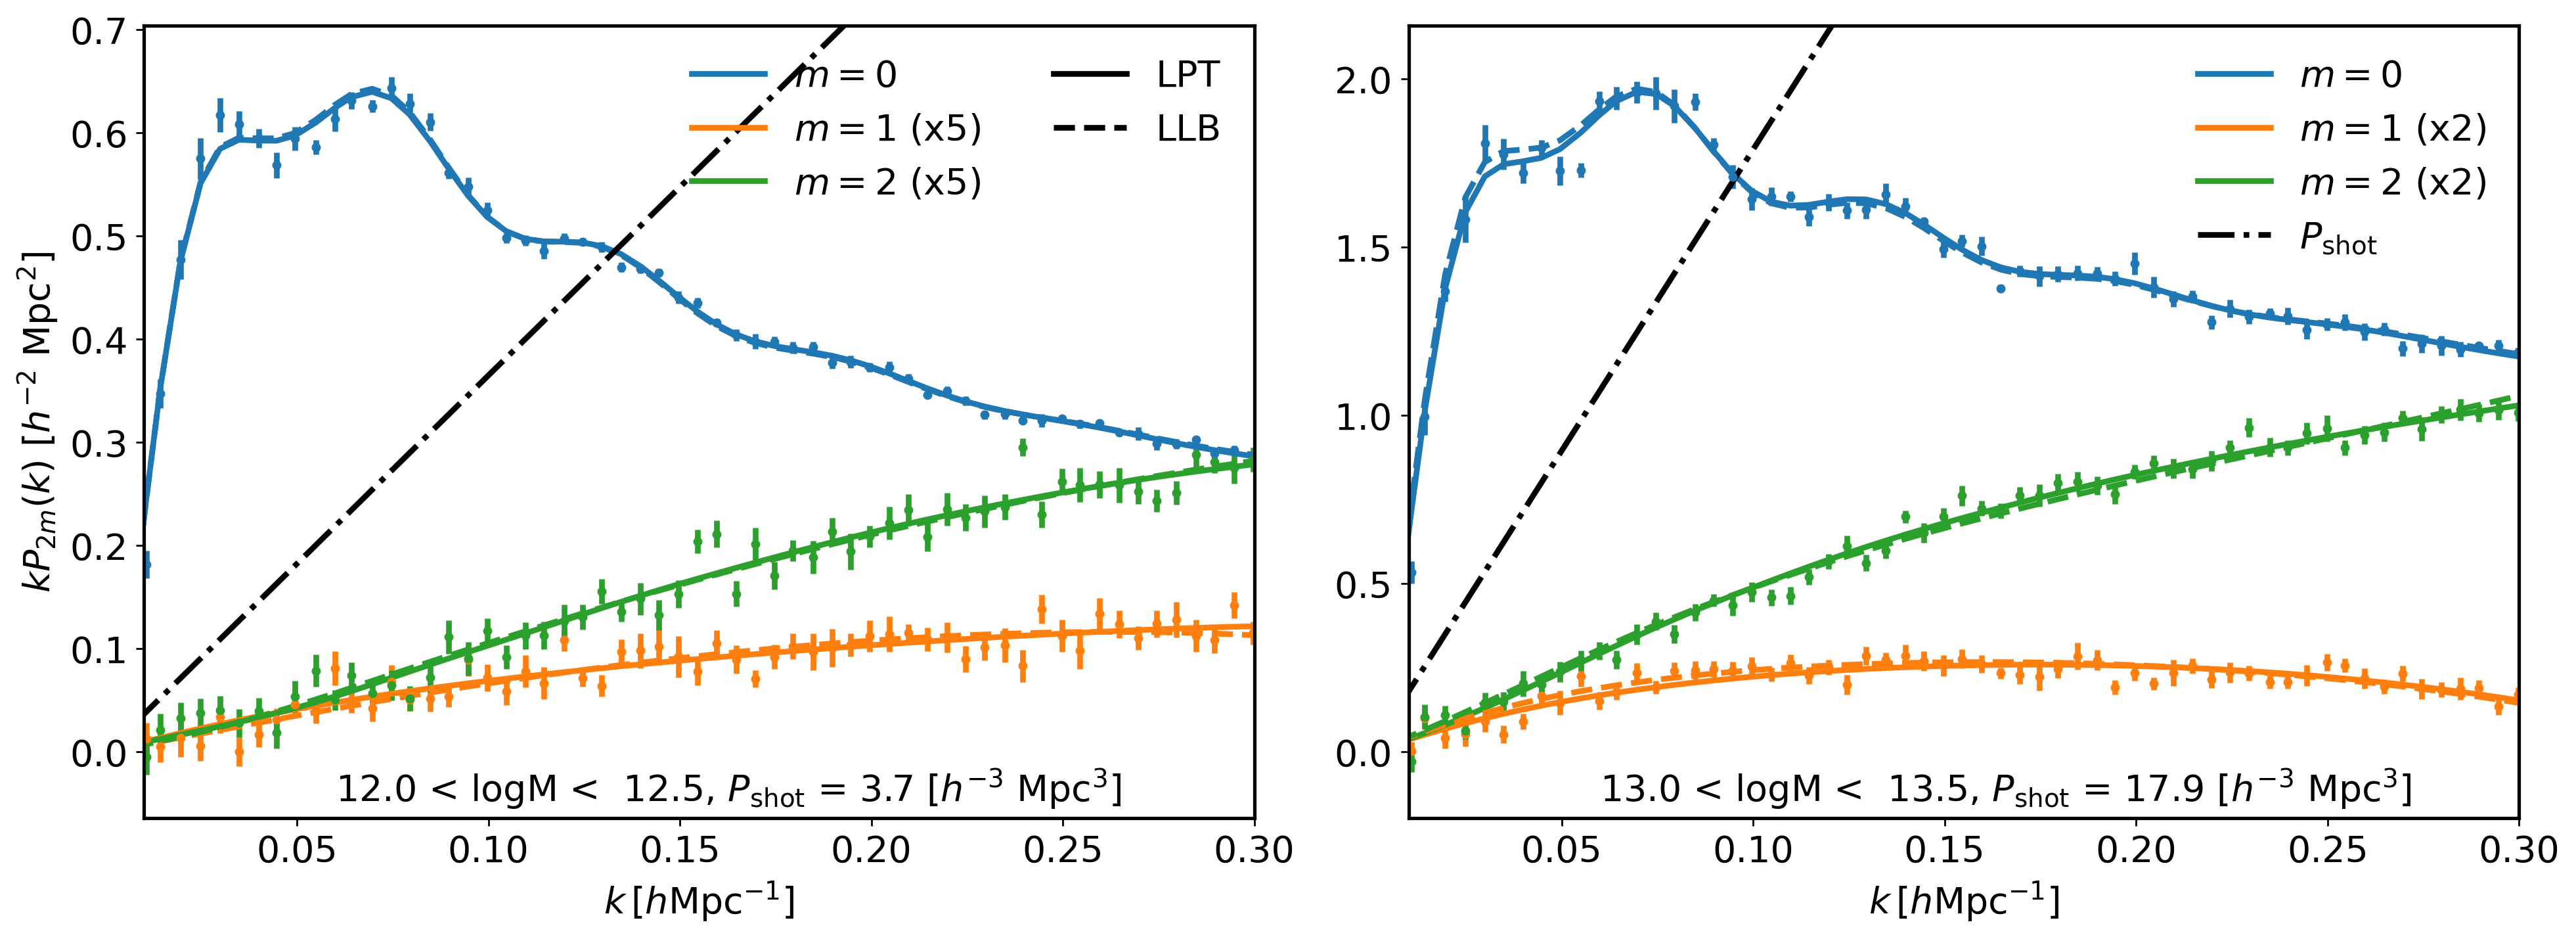

In [20]:
mfacs = [5,2]

plt.figure(dpi=250, figsize=(16, 6), facecolor='w')

for ii, (M1, M2) in enumerate([ ('1e12', '3.16e12'), ('1e13', '3.16e13') ]):

    print(ii, M1,M2)
    
    m1fac = mfacs[ii]
    m2fac = mfacs[ii]
    
    kdats, spectra, errs, dvec, dcov, Pshot = load_spin_data(M1,M2)
    
    iis = (kdats > 0.02) * (kdats < 0.3)

    xdat = kdats[iis]
    ydat = np.concatenate( (spectra['20'][iis], spectra['21'][iis], spectra['22'][iis]))
    sigmas = np.sqrt(dcov)[np.concatenate((iis,iis,iis))]

    res = curve_fit(curve_func, xdat, ydat, sigma=sigmas)
    ps = curve_func(kdats, *res[0])
    p0 = ps[:60]
    p1 = ps[60:120]
    p2 = ps[120:]
    print(*res[0])
    dof = len(xdat)*3 - len(res[0])
    print('chi2, dof:', np.sum((curve_func(xdat, *res[0])-ydat)**2 / sigmas**2), dof)

    
    res = curve_fit(curve_func_local, xdat, ydat, sigma=sigmas)
    print(*res[0])
    dof = len(xdat)*3 - len(res[0])
    print('chi2, dof:', np.sum((curve_func_local(xdat, *res[0])-ydat)**2 / sigmas**2), dof)

    ps = curve_func_local(kdats, *res[0])
    p0_local = ps[:60]
    p1_local = ps[60:120]
    p2_local = ps[120:]
    
    plt.subplot(1,2,ii+1)

    plt.errorbar(kdats, kdats * spectra['20'], yerr=kdats*errs['20'],fmt='.',c='C0' )
    plt.errorbar(kdats, m1fac * kdats * spectra['21'], yerr=m1fac * kdats*errs['21'], fmt='.',c='C1' )
    plt.errorbar(kdats, m2fac * kdats * spectra['22'], yerr=m2fac * kdats*errs['22'], fmt='.',c='C2' )

    plt.plot(kdats, kdats * p0,label=r'$m=0$')
    plt.plot(kdats, m1fac * kdats * p1,label=r'$m=1$ (x%d)'%(m1fac))
    plt.plot(kdats, m2fac * kdats * p2,label=r'$m=2$ (x%d)'%(m2fac))
    
    plt.plot(kdats, kdats * p0_local,'C0--')
    plt.plot(kdats, m1fac * kdats * p1_local,'C1--')
    plt.plot(kdats, m2fac * kdats * p2_local,'C2--')
    
    plt.plot(kdats, kdats * Pshot, 'k-.')
    
    plt.xlim(0.01,0.3)
    plt.ylim(-0.1 * np.max(kdats*p0), 1.1 * np.max(kdats*p0))
    
    plt.text(0.06, -0.075 * np.max(kdats*p0), r'%.1f < logM <  %.1f, $P_{\rm shot}$ = %.1f [$h^{-3}$ Mpc$^3$]'%(np.log10(float(M1)),np.log10(float(M2)),Pshot))

    plt.xlabel(r'$k\, [h {\rm Mpc}^{-1}]$')
    if ii==0:
        plt.ylabel(r'$k P_{2m}(k)$ [$h^{-2}$ Mpc$^2$]')
    
    if ii==0:
        plt.plot(0,0,'k',label='LPT')
#         plt.plot(0,0,'k:',label=r'CSN')
        plt.plot(0,0,'k--',label=r'LLB')
        plt.legend(loc='upper right',ncol=2, framealpha=False)
    else:
        plt.plot(0,0,'k-.',label=r'$P_{\rm shot}$')
        plt.legend(loc='upper right', framealpha=False)
    
plt.tight_layout()

plt.savefig('fits_to_data_LLB.pdf')

That's a wrap!